# Simulation

Simulation is an important step to check that models produce expected patterns of behaviour. The process involves taking a series of task stimuli and feeding them into a learning model and observation model with a given set of parameter values to produce behaviour predicted by these particular parameter values.

To facilitate this process, the ``DMModel`` class has a ``simulate`` method, that provides the ability to simulate behaviour for a given model across parameter values, and produces outputs necessary to evaluate the simulated behaviour.

At a basic level, the ``simulate`` method can be called with a series of outcomes (e.g. reward/no reward for a given stimulus) as a .txt file or a numpy array, along with dictionaries of parameter values for the learning and observation models. This will return the simulated data and the location where this data was saved (if an output filename was specified). For example:


Finished simulating


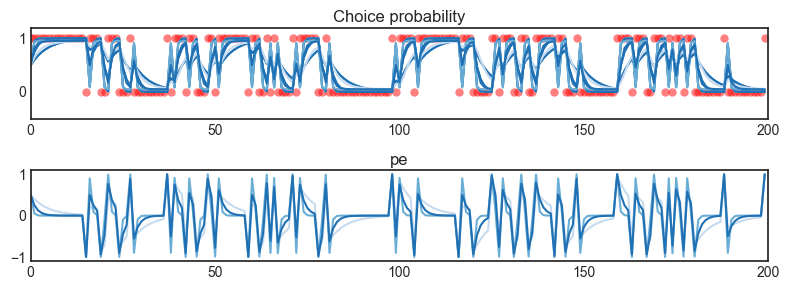

In [4]:
% matplotlib inline
from DMpy.model import DMModel, Parameter
from DMpy.learning import rescorla_wagner
from DMpy.observation import softmax
from DMpy.utils import load_example_outcomes
import numpy as np
import os

value = Parameter('value', 'fixed', mean=0.5, dynamic=True)
alpha = Parameter('alpha', 'uniform', lower_bound=0, upper_bound=1)
beta = Parameter('beta', 'fixed', mean=3)

rw_model = DMModel(rescorla_wagner, [value, alpha], softmax, [beta])

outcomes = load_example_outcomes()

sim_results, sim_file = rw_model.simulate(outcomes, learning_parameters={'value': 0.5, 'alpha': 0.3]}, 
                         observation_parameters={'beta':3}, plot=True)


This will simulate behaviour according to the model's responses to the given outcomes at the provided parameter values. By "behaviour" here we refer to the probability of choosing a given action. The ``simulate`` method will also produce plots of the simulated probability, along with any other variables provided by the learning and observation models (such as prediction errors or any other values returned by the model functions).

## Saving simulated data

It can be useful to save the output of a simulation run to a file in the same format as real subjects' data, and it is possible to do this by providing a value for the ``output_file`` argument of the ``simulate`` method. This will simulate choices on each trial based on the calculated probability of choosing a given action, and write these to a response file, along with subject IDs (subjects are named after the model parameters used to simulate them) and columns listing the provided parameter values for the simulation.


In [7]:
sim_results, sim_file = rw_model.simulate(outcomes, learning_parameters={'value': 0.5, 'alpha': 0.3}, 
                         observation_parameters={'beta':3}, output_file='simulated_responses.txt')

Finished simulating
Saving simulated responses to simulated_responses.txt
simulated_responses.txt


## Accessing simulated data

Results of the simulation returned by the simulate method and are saved in the ``simulated`` attribute of the model. This takes the format of a dictionary containing the parameters values provided to the learning model, those provided to the observation model, and the results of the simulation. The simulation results take the form of a dictionary with entries representing the name of every variable returned by the model (e.g. estimated value, action probability, prediction errors etc.) and their value. This makes it relatively simple to access results from a range of simulations. For example, to retrieve the prediction errors given by the most recent simulation, we can use the following code:


In [10]:
# Using the returned values
prediction_errors = sim_results['sim_results']['pe']
print prediction_errors[:10]

# Using the stored values
prediction_errors = rw_model.simulated['sim_results']['pe']
print prediction_errors[:10]

[ 0.5         0.35        0.245       0.1715      0.12005     0.084035
  0.0588245   0.04117715  0.02882401  0.0201768 ]
[ 0.5         0.35        0.245       0.1715      0.12005     0.084035
  0.0588245   0.04117715  0.02882401  0.0201768 ]


The position of the values returned by the ``simulate`` method relative to each trial is important to be aware of, and differs depending on the type of variable being returned. The estimated value, and any other variable that is entered into the learning model's calculation at each step is provided *prior* to the model seeing the outcome of the trial. For instance, if we set the initial estimated value at 0.5, the estimated value in the first trial of the simulated data will be 0.5. In contrast, other outputs (such as prediction errors) are provided on the same trial as the outcome. So for example the first prediction error would be the prediction error produced by the first trial.

## Simulating multiple subjects & runs

It is also possible to simulate multiple subjects by providing a value for the ``n_subjects`` argument of the ``simulate`` method. This will generate additional sets of randomly determined choice data for each subject. Note that this only has an effect if there is some degree of randomness in the simulated data, for example when simulating binary choices from estimated choice probabilities.

It is also possible to simulate multiple runs per subject by using the ``runs_per_subject`` argument. If an integer is given, a "Run" column will be produced in the response file, and each run for the subject will use the same parameter values. Note that this process is essentially identical to simulating multiple subjects except for the labelling in the output file (i.e. being labelled as a run instead of a subject) - this simply makes it simpler when fitting models to simulated data that involve multiple runs.

If multiple subjects are simulated, the arrays for each variable returned by the simulation become two-dimensional (n_trials, n_subjects).

In [12]:
sim_results, sim_file = rw_model.simulate(outcomes, learning_parameters={'value': 0.5, 'alpha': 0.3}, 
                         observation_parameters={'beta':3}, n_subjects=3)
prediction_errors = sim_results['sim_results']['pe']
print prediction_errors.shape

Finished simulating
(200L, 3L)


## Simulating using a range of parameter values

It is possible to simulate data from multiple values of a given parameter by simply entering the parameter values as a list rather than a single value. If each parameter has an equal number of values and the ``combinations`` argument is set to false, each simulation will represent a position in the lists of parameters. For example, if given the learning parameters ``{'a' : [0, 1], 'b': [0.1, 0.2]``, the simulation will generate one set of simulated data where ``a`` is set to 0 and ``b`` is set to 0.1, and another set of data where ``a`` is 1 and ``b`` is 0.2.

If the combinations argument is set to true, data will be simulated from every combination of the parameters provided. In the above example, this would lead to 4 simulations (0 & 0.1, 0 & 0.2, 1 & 0.1, 1 & 0.2).

The outcomes provided to the simulate method can take the form of an array with different outcomes for each subject (i.e. an array of the shape n_trials, n_subjects), or if a one-dimensional outcome array is provided this will be used for each combination of parameter values.

# Parameter recovery

Parameter recovery tests the ability to determine parameter values from observed behavioural data simulated with known parameter values. For example, if we simulated behaviour using a Rescorla-Wagner learning model with an alpha value of 3, our model fitting procedures should return an alpha value of 3 when we attempt to fit a Rescorla-Wagner model to this data. DMpy provides a couple of functions to assist with this process. Firstly, when data is simulated using the ``DMModel`` class ``simulate`` method and saved to a csv file, the generated response file will include columns containing the values of each parameter used to simulate the data.

If a response file including these columns is fed into any of the ``DMModel`` class's fit methods, it will automatically include these values in its output table for each subject and estimate Pearson correlations between the true and recovered parameter values (saved in the ``.recovery_correlations`` attribute of the model), along with producing plots to illustrate these.

In order for this to work properly, it's advisable to simulate across a range of parameter values. This is simple to do by providing lists of values in the parameter dictionary rather than single values. If multiple values are provided for more than one parameter, all possible combinations of these parameter values will be simulated. Be aware that if many parameter values are provided, this can rapidly lead to a *very* large number of simulated datasets and cause problems!

This is an example of parameter recovery with a Rescorla-Wagner model, where we're assessing our ability to recover the alpha parameter. To simulate across a range of values of alpha, we provide a range from 0.1 to 0.9 in steps of 0.1 using ``np.arange(0.1, 1, 0.1)``.

Finished simulating
Saving simulated responses to rw_simulated_responses.txt


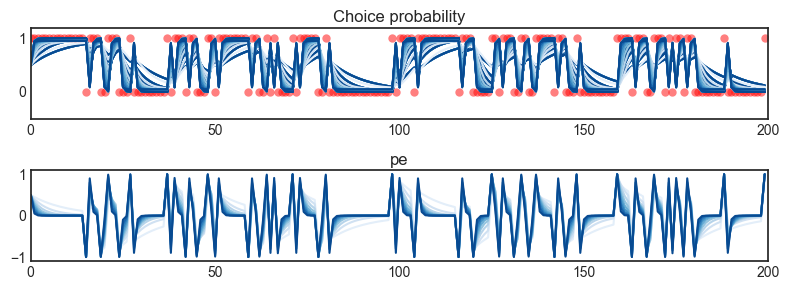

In [17]:
sim_results, sim_file = rw_model.simulate(outcomes, 
                                          learning_parameters={'value': 0.5, 'alpha': np.arange(0.1, 1, 0.1)}, 
                         observation_parameters={'beta':3}, combinations=True, plot=True,
                                          output_file='rw_simulated_responses.txt')